# Best y for train

Models:

- MLP
- GMF

Variations:

- DeepGroup (avg)
- Expert Softmax
- DL Group AGG with mean
- IPA

In [1]:
import pandas as pd
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=2)

"""
results/ml1m/groups-2-mlp_gpa_avg.csv
results/ml1m/groups-2-mlp_gpa_expert.csv
results/ml1m/groups-2-mlp_gpa_mlp_mean.csv
results/ml1m/groups-2-mlp_gpa_softmax.csv
results/ml1m/groups-2-mlp_ipa.csv
"""
"""
@param model: mlp o gmf
"""
def get_models_files(model):
    return {
        'ipa_'+model: model+'_ipa',
        'mo_avg_'+model: model+'_gpa_avg',
        #'mo_expert_'+model: model+'_gpa_expert',
        #'mo_softmax_'+model: model+'_gpa_softmax',
        'mlp_mean_'+model: model+'_gpa_mlp_mean',
    }

def get_all_models_files():
    dd = get_models_files('gmf')
    dd.update(get_models_files('mlp'))
    return dd


"""
@param labels_models: labels_models list
@param ds: dataset name
"""
def get_error(models_files, ds):
    datapath=f'../data/grupos/{ds}/'
    restulspath=f'../results/{ds}/'

    models = models_files.keys()
    
    # Load data
    groups = {}

    fromngroups=2
    tongroups=10

    # Load groups data
    for g in range(fromngroups,tongroups+1):
        groups[g] = pd.read_csv(f"{datapath}groups-{g}-test.csv")
        groups[g]['g'] = g
    
    
    # Load model predictions
    for g in range(fromngroups,tongroups+1):
        for model in models:
            file_name = models_files[model]
            groups[g][model] = pd.read_csv(
                f"{restulspath}groups-{g}-{file_name}.csv",
                header=0,
                names=["data"]
            )['data']

    # Compute error
    for g in range(fromngroups,tongroups+1):    # Each group
        for m in models:                        # Each model
            for gi in range(1,g+1):             # Each rating in group
                groups[g][m+'-error-'+str(gi)] = abs(groups[g]['rating-'+str(gi)] - groups[g][m])
                groups[g][m+'-error2-'+str(gi)] = (groups[g]['rating-'+str(gi)] - groups[g][m])**2

    for g in range(fromngroups,tongroups+1):    # Each group
        for m in models:                        # Each model
            groups[g][m+'-ERROR'] = groups[g].filter(regex='^'+m+'-error-',axis=1).mean(axis=1, skipna=True)
            groups[g][m+'-ERROR2'] = groups[g].filter(regex='^'+m+'-error2-',axis=1).mean(axis=1, skipna=True)
    
    # Join dict of groups
    results = pd.concat(groups, join='inner', ignore_index=True)
    # Calculate means
    means = results.groupby('g').mean()

    return means, results, groups

In [2]:

"""
@data: dataframe
@val: "ERROR" o "ERROR2"
@val_text: MAE o MSE
@model_name: Model name for title
@dataset_text: Dataset name for title: "ML1M", Anime", etc.
"""
def barplot(data, val, val_text, model_name, dataset_text):
    model_files = get_all_models_files()
    models = [m+'-'+val for m in model_files.keys()]
    df = data[['g']+models]
    df.columns = ['g']+list(model_files.keys())
    
    fig = df.groupby('g').mean().plot(
        kind='bar',
        yerr=df.groupby('g').std(),
        figsize=(30, 5)
    )
    fig.legend(model_files.keys(), bbox_to_anchor=(1.0, 1.0))
    fig.set(title=f'({model_name}) {dataset_text}')
    fig.set_xlabel('Group Size')
    fig.set_ylabel(val_text)
    fig.plot()

"""
@data: dataframe
@val: "ERROR" o "ERROR2"
@val_text: MAE o MSE
@model_name: Model name for title
@dataset_text: Dataset name for title: "ML1M", Anime", etc.
"""
def lineplot(data, val, val_text, model_name, dataset_text):
    model_files = get_all_models_files()
    models = [m+'-'+val for m in model_files.keys()]
    long_data = pd.melt(data[['g']+models], id_vars =['g'], value_vars=models)
    ax = sns.relplot(
        data=long_data.groupby(['g','variable']).mean(), kind="line",
        x="g", y="value", hue="variable",
        height=15, aspect=1.5
    )
    ax.set(title=f'({model_name}) {dataset_text}')
    ax.axes[0,0].set_xlabel('Group Size')
    ax.axes[0,0].set_ylabel(val_text)
    plt.show()


"""
@data: dataframe
@val: "ERROR" o "ERROR2"
@val_text: MAE o MSE
@model_name: Model name for title
@dataset_text: Dataset name for title: "ML1M", Anime", etc.
"""
def boxplot(data, val, val_text, model_name, dataset_text,
            models=None, showfliers = False, palette="colorblind",
            half_width=False
           ):
    sns.set_palette(palette)
    model_files = get_all_models_files()
    if models is None:
        models = [m+'-'+val for m in model_files.keys()]
    
    long_data = pd.melt(data[['g']+models], id_vars =['g'], value_vars=models,
                       var_name='model', value_name='e')
    if half_width:
        plt.figure(figsize=(12,15))
    else:
        #previous paper
        #plt.figure(figsize=(32,15))
        #paper size
        plt.figure(figsize=(25,8))
    
    fig = sns.boxplot(
        data=long_data,
        x='g',
        y='e',
        hue='model',
        showmeans=True,
        showfliers = showfliers,
        meanprops={"marker": 1, "markeredgecolor": "yellow", "markersize": "16"}
    )
    handles, _ = fig.get_legend_handles_labels()
    #model_names=model_files.keys()
    model_names=[
        'IPA-GMF',
        'MO-AVG-GMF',
        'GGMF',
        'IPA-NCF',
        'MO-AVG-NCF',
        'GNCF',
    ]
    fig.legend(handles, model_names, bbox_to_anchor=(1.19, 1.0), loc='upper right')
    #paper production
    #fig.set(title=f'({model_name}) {dataset_text}')
    fig.set_xlabel('Group Size')
    fig.set_ylabel(val_text)
    fig.plot()

In [3]:
#DS='ml1m'
#DS='ft'
#DS='anime'
#DS='netflix'
pd.set_option('display.max_columns', None)

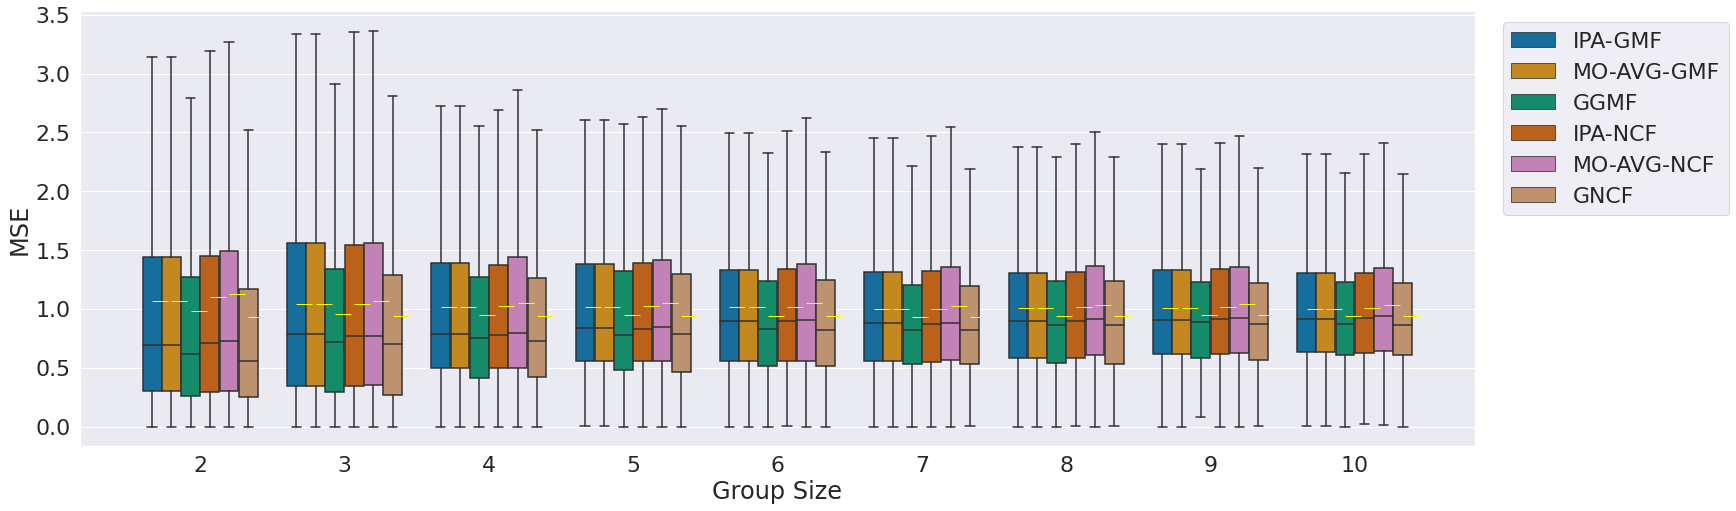

In [4]:
means, ml100k_results, results_dict = get_error(get_all_models_files(), 'ml100k')
boxplot(ml100k_results, "ERROR2", "MSE", "GMF vs MLP", "ML100K", half_width=False)

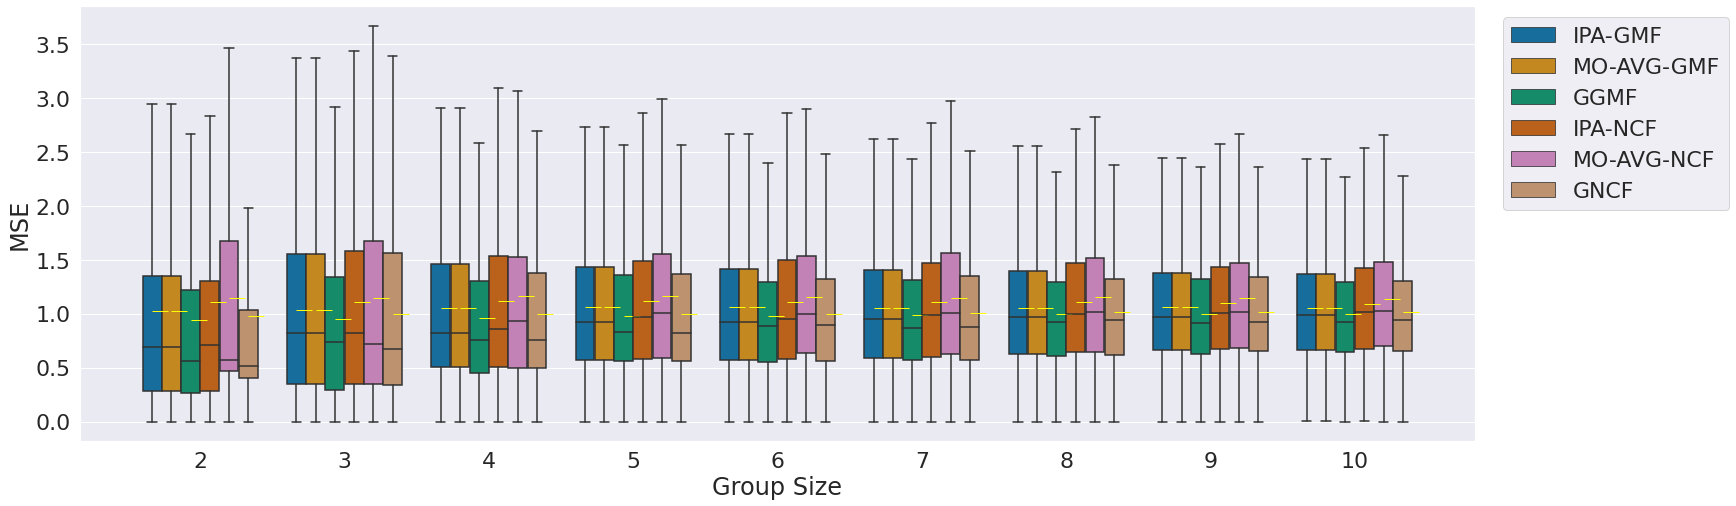

In [5]:
means, ml1m_results, results_dict = get_error(get_all_models_files(), 'ml1m')
boxplot(ml1m_results, "ERROR2", "MSE", "GMF vs MLP", "ML1M", half_width=False)

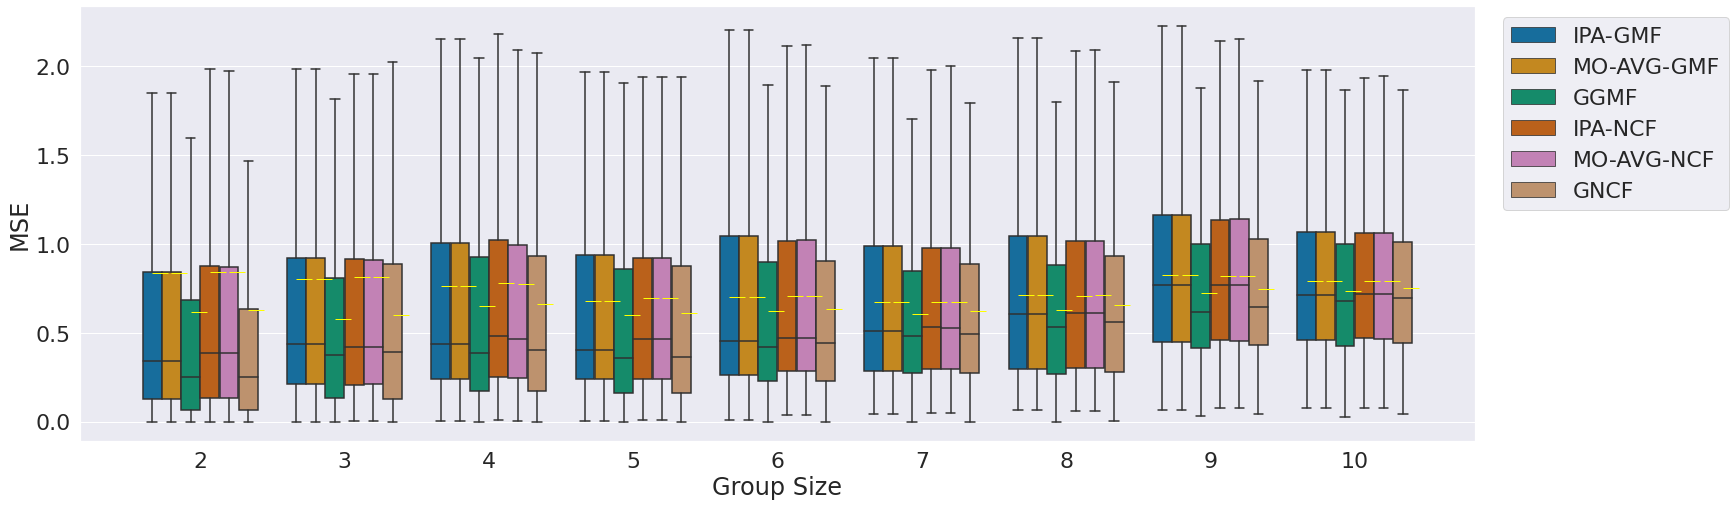

In [6]:
means, ft_results, results_dict = get_error(get_all_models_files(), 'ft')
boxplot(ft_results, "ERROR2", "MSE", "GMF vs MLP", "FilmTrust", half_width=False)

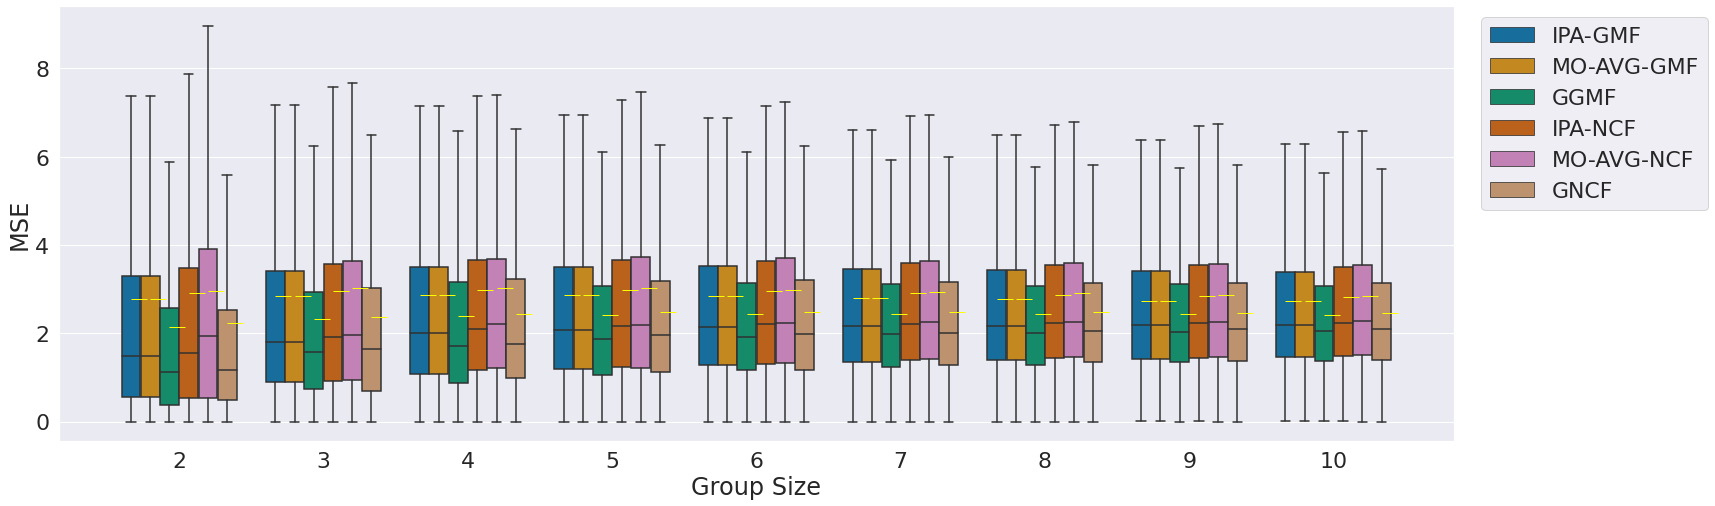

In [7]:
means, anime_results, results_dict = get_error(get_all_models_files(), 'anime')
boxplot(anime_results, "ERROR2", "MSE", "GMF vs MLP", "Anime", half_width=False)

In [ ]:
means, mlp_ml100k_results, results_dict = get_error(get_models_files('mlp'), 'ml100k')
#barplot(mlp_ml100k_results, "ERROR", "MAE", "Individual model MLP", "ML100K")
#barplot(mlp_ml100k_results, "ERROR2", "MSE", "Individual model MLP", "ML100K")
#lineplot(mlp_ml100k_results, "ERROR", "MAE", "Individual model MLP", "ML100K")
#lineplot(mlp_ml100k_results, "ERROR2", "MSE", "Individual model MLP", "ML100K")

In [ ]:
boxplot(mlp_ml100k_results, "ERROR", "MAE", "Individual model MLP", "ML100K", models=list(get_models_files('mlp').keys()))
boxplot(mlp_ml100k_results, "ERROR2", "MSE", "Individual model MLP", "ML100K", models=list(get_models_files('mlp').keys()))

In [ ]:
means, gmf_ml100k_results, results_dict = get_error(get_models_files('gmf'), 'ml100k')
#barplot(gmf_ml100k_results, "ERROR", "MAE", "Individual model GMF", "ML100K")
#barplot(gmf_ml100k_results, "ERROR2", "MSE", "Individual model GMF", "ML100K")
#lineplot(gmf_ml100k_results, "ERROR", "MAE", "Individual model GMF", "ML100K")
#lineplot(gmf_ml100k_results, "ERROR2", "MSE", "Individual model GMF", "ML100K")

In [ ]:
sns.set_palette("colorblind")
boxplot(gmf_ml100k_results, "ERROR", "MAE", "Individual model GMF", "ML100K")
boxplot(gmf_ml100k_results, "ERROR2", "MSE", "Individual model GMF", "ML100K")

In [ ]:
# GMF vs MLP
ml100k = pd.DataFrame(mlp_ml100k_results[['g','mlp_mean-ERROR2']])
ml100k.columns=['g','mlp']
ml100k['gmf'] = gmf_ml100k_results['mlp_mean-ERROR2']
boxplot(ml100k, None, "MSE", "GMF vs MLP", "ML100K", ['gmf','mlp'], palette="Set2", half_width=True)

In [ ]:
means, mlp_ml1m_results, results_dict = get_error(get_models_files('mlp'), 'ml1m')
#barplot(mlp_ml1m_results, "ERROR", "MAE", "Individual model MLP", "ML1M")
#barplot(mlp_ml1m_results, "ERROR2", "MSE", "Individual model MLP", "ML1M")
#lineplot(mlp_ml1m_results, "ERROR", "MAE", "Individual model MLP", "ML1M")
#lineplot(mlp_ml1m_results, "ERROR2", "MSE", "Individual model MLP", "ML1M")

In [ ]:
boxplot(mlp_ml1m_results, "ERROR", "MAE", "Individual model MLP", "ML1M")
boxplot(mlp_ml1m_results, "ERROR2", "MSE", "Individual model MLP", "ML1M")

In [ ]:
means, gmf_ml1m_results, results_dict = get_error(get_models_files('gmf'), 'ml1m')
#barplot(gmf_ml1m_results, "ERROR", "MAE", "Individual model GMF", "ML1M")
#barplot(gmf_ml1m_results, "ERROR2", "MSE", "Individual model GMF", "ML1M")
#lineplot(gmf_ml1m_results, "ERROR", "MAE", "Individual model GMF", "ML1M")
#lineplot(gmf_ml1m_results, "ERROR2", "MSE", "Individual model GMF", "ML1M")

In [ ]:
boxplot(gmf_ml1m_results, "ERROR", "MAE", "Individual model GMF", "ML1M")
boxplot(gmf_ml1m_results, "ERROR2", "MSE", "Individual model GMF", "ML1M")

In [ ]:
gmf_ml1m_results.columns

In [ ]:
# GMF vs MLP
ml1m = pd.DataFrame(mlp_ml1m_results[['g','ipa-ERROR2', 'mlp_mean-ERROR2']])
ml1m.columns=['g','ipa-mlp','mlp']
ml1m['gmf'] = gmf_ml1m_results['mlp_mean-ERROR2']
ml1m['ipa-gmf'] = gmf_ml1m_results['ipa-ERROR2']
boxplot(ml1m, None, "MSE", "GMF vs MLP", "ML1M", ['gmf','mlp'], palette="Set2", half_width=True)

In [ ]:
boxplot(ml1m, None, "MSE", "GMF vs MLP", "ML1M", ['ipa-gmf', 'mlp'], palette="Set1", half_width=True)

In [ ]:
means, mlp_ft_results, results_dict = get_error(get_models_files('mlp'), 'ft')
#barplot(mlp_ft_results, "ERROR", "MAE", "Individual model MLP", "FT")
#barplot(mlp_ft_results, "ERROR2", "MSE", "Individual model MLP", "FT")
#lineplot(mlp_ft_results, "ERROR", "MAE", "Individual model MLP", "FT")
#lineplot(mlp_ft_results, "ERROR2", "MSE", "Individual model MLP", "FT")

In [ ]:
boxplot(mlp_ft_results, "ERROR", "MAE", "Individual model MLP", "FT")
boxplot(mlp_ft_results, "ERROR2", "MSE", "Individual model MLP", "FT")

In [ ]:
means, gmf_ft_results, results_dict = get_error(get_models_files('gmf'), 'ft')
#barplot(gmf_ft_results, "ERROR", "MAE", "Individual model GMF", "FT")
#barplot(gmf_ft_results, "ERROR2", "MSE", "Individual model GMF", "FT")
#lineplot(gmf_ft_results, "ERROR", "MAE", "Individual model GMF", "FT")
#lineplot(gmf_ft_results, "ERROR2", "MSE", "Individual model GMF", "FT")

In [ ]:
boxplot(gmf_ft_results, "ERROR", "MAE", "Individual model GMF", "FT")
boxplot(gmf_ft_results, "ERROR2", "MSE", "Individual model GMF", "FT")

In [ ]:
# GMF vs MLP
ft = pd.DataFrame(mlp_ft_results[['g','mlp_mean-ERROR2']])
ft.columns=['g','mlp']
ft['gmf'] = gmf_ft_results['mlp_mean-ERROR2']
boxplot(ft, None, "MSE", "GMF vs MLP", "FT", ['gmf','mlp'], palette="Set2", half_width=True)

In [ ]:
means, mlp_anime_results, results_dict = get_error(get_models_files('mlp'), 'anime')
#barplot(mlp_anime_results, "ERROR", "MAE", "Individual model MLP", "ANIME")
#barplot(mlp_anime_results, "ERROR2", "MSE", "Individual model MLP", "ANIME")
#lineplot(mlp_anime_results, "ERROR", "MAE", "Individual model MLP", "ANIME")
#lineplot(mlp_anime_results, "ERROR2", "MSE", "Individual model MLP", "ANIME")

In [ ]:
boxplot(mlp_anime_results, "ERROR", "MAE", "Individual model MLP", "ANIME")
boxplot(mlp_anime_results, "ERROR2", "MSE", "Individual model MLP", "ANIME")

In [ ]:
means, gmf_anime_results, results_dict = get_error(get_models_files('gmf'), 'anime')
#barplot(gmf_anime_results, "ERROR", "MAE", "Individual model GMF", "ANIME")
#barplot(gmf_anime_results, "ERROR2", "MSE", "Individual model GMF", "ANIME")
#lineplot(gmf_anime_results, "ERROR", "MAE", "Individual model GMF", "ANIME")
#lineplot(gmf_anime_results, "ERROR2", "MSE", "Individual model GMF", "ANIME")

In [ ]:
boxplot(gmf_anime_results, "ERROR", "MAE", "Individual model GMF", "ANIME")
boxplot(gmf_anime_results, "ERROR2", "MSE", "Individual model GMF", "ANIME")

In [ ]:
# GMF vs MLP
anime = pd.DataFrame(mlp_anime_results[['g','mlp_mean-ERROR2']])
anime.columns=['g','mlp']
anime['gmf'] = gmf_anime_results['mlp_mean-ERROR2']
boxplot(anime, None, "MSE", "GMF vs MLP", "ANIME", ['gmf','mlp'], palette="Set2", half_width=True)

In [ ]:
means, results, results_dict = get_error(get_models_files('mlp'), 'anime')
barplot(results, "ERROR", "MAE", "Individual model MLP", "ANIME")
barplot(results, "ERROR2", "MSE", "Individual model MLP", "ANIME")

means, results, results_dict = get_error(get_models_files('gmf'), 'anime')
barplot(results, "ERROR", "MAE", "Individual model GMF", "ANIME")
barplot(results, "ERROR2", "MSE", "Individual model GMF", "ANIME")

In [ ]:
models = [m+'-ERROR' for m in get_models_files('mlp').keys()]
long_data = pd.melt(results[['g']+models], id_vars =['g'], value_vars=models)
ax = sns.relplot(
    data=long_data.groupby(['g','variable']).mean(), kind="line",
    x="g", y="value", hue="variable",
    height=15, aspect=1.5
)
ax.set(title='MAE ML1M')
ax.axes[0,0].set_xlabel('Group Size')
ax.axes[0,0].set_ylabel('MAE')
plt.show()

In [ ]:
models = [m+'-ERROR2' for m in get_models_files('mlp').keys()]
long_data = pd.melt(results[['g']+models], id_vars =['g'], value_vars=models)
ax = sns.relplot(
    data=long_data.groupby(['g','variable']).mean(), kind="line",
    x="g", y="value", hue="variable",
    height=15, aspect=1.5
)
ax.set(title='MSE ML1M')
ax.axes[0,0].set_xlabel('Group Size')
ax.axes[0,0].set_ylabel('MSE')
plt.show()

In [ ]:
means, results, results_dict = get_error(get_models_files('mlp'), 'ft')

In [ ]:
models = [m+'-ERROR' for m in get_models_files('mlp').keys()]
long_data = pd.melt(results[['g']+models], id_vars =['g'], value_vars=models)
ax = sns.relplot(
    data=long_data.groupby(['g','variable']).mean(), kind="line",
    x="g", y="value", hue="variable",
    height=15, aspect=1.5
)
ax.set(title='MAE FT')
ax.axes[0,0].set_xlabel('Group Size')
ax.axes[0,0].set_ylabel('MAE')
plt.show()

In [ ]:
models = [m+'-ERROR2' for m in get_models_files('mlp').keys()]
long_data = pd.melt(results[['g']+models], id_vars =['g'], value_vars=models)
ax = sns.relplot(
    data=long_data.groupby(['g','variable']).mean(), kind="line",
    x="g", y="value", hue="variable",
    height=15, aspect=1.5
)
ax.set(title='MSE FT')
ax.axes[0,0].set_xlabel('Group Size')
ax.axes[0,0].set_ylabel('MSE')
plt.show()

In [ ]:
means, results, results_dict = get_error(get_models_files('mlp'), 'anime')

In [ ]:
models = [m+'-ERROR' for m in get_models_files('mlp').keys()]
long_data = pd.melt(results[['g']+models], id_vars =['g'], value_vars=models)
ax = sns.relplot(
    data=long_data.groupby(['g','variable']).mean(), kind="line",
    x="g", y="value", hue="variable",
    height=15, aspect=1.5
)
ax.set(title='MAE ANIME')
ax.axes[0,0].set_xlabel('Group Size')
ax.axes[0,0].set_ylabel('MAE')
plt.show()

In [ ]:
models = [m+'-ERROR2' for m in get_models_files('mlp').keys()]
long_data = pd.melt(results[['g']+models], id_vars =['g'], value_vars=models)
ax = sns.relplot(
    data=long_data.groupby(['g','variable']).mean(), kind="line",
    x="g", y="value", hue="variable",
    height=15, aspect=1.5
)
ax.set(title='MSE ANIME')
ax.axes[0,0].set_xlabel('Group Size')
ax.axes[0,0].set_ylabel('MSE')
plt.show()